# ADA : Replication of paper : Friendship and Mobility

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from process_functions import *
from visualisation_functions import *

## 1) Import needed files :

In [2]:
#import checkin dataset for brightkite
BRIGHTKITE_CHECKIN_PATH = os.path.join("data","loc-brightkite_totalCheckins.txt.gz")
checkin_brightkite=pd.read_csv(BRIGHTKITE_CHECKIN_PATH,compression='gzip',delimiter='\t',names=["User", "check-in time", "latitude", "longitude","location id"])

#import edges dataset for brightkite
BRIGHTKITE_EDGES_PATH = os.path.join("data","loc-brightkite_edges.txt.gz")
edges_brightkite=pd.read_csv(BRIGHTKITE_EDGES_PATH,compression='gzip',delimiter='\t',error_bad_lines=False,warn_bad_lines=False,names=["following", "followed"])

In [3]:
#import checkin dataset for gowalla
GOWALLA_CHECKIN_PATH = os.path.join("data","loc-gowalla_totalCheckins.txt.gz")
checkin_gowalla=pd.read_csv(GOWALLA_CHECKIN_PATH,compression='gzip',delimiter='\t',names=["User", "check-in time", "latitude", "longitude","location id"],skipinitialspace=True)                                                                                                                                               

#import edges dataset for brightkite
GOWALLA_EDGES_PATH = os.path.join("data","loc-gowalla_edges.txt.gz")
edges_gowalla=pd.read_csv(GOWALLA_EDGES_PATH,compression='gzip',delimiter='\t',error_bad_lines=False,warn_bad_lines=False,names=["following", "followed"],skipinitialspace=True,index_col=None)

## 2) Treating data :

After visualising the data, we see that :  
- the last column just corresponds to the location id
- the first column corresponds to a user : different number corresponds to a different user ==> we will group by the number of the first column in tehe future
- second column : date and hour 
- third and fourth column seem to be latitude and longitude.
- by exploring the data we see that sometimes the third and forth column are both equal to 0 : we assume it's an error in the dataset and drop the line

In [4]:
#we divise by 2 because edges are bidimentional
print('number of edges for Gowalla',int(0.5*edges_gowalla.shape[0]))
print('number of edges for Brightkite',int(0.5*edges_brightkite.shape[0]))

# calculate the number of users
print("number of users in Gowalla  :",edges_gowalla.groupby('following').count().shape[0])
print("number of users in Brightkite  :",edges_brightkite.groupby('following').count().shape[0])

number of edges for Gowalla 950327
number of edges for Brightkite 214078
number of users in Gowalla  : 196591
number of users in Brightkite  : 58228


$\Rightarrow$ We see that numbers are the same as the ones givenin the paper

* Now we clean our dataset by :  
1) Dropping nan values (inf,-inf,not defined number)   
2) Dropping aberrant values (values where the latitude isn't in the interval [0,90] and values where the longitude isn't in the interval [-180,180]

In [5]:
checkin_brightkite=clean_data(checkin_brightkite)
checkin_gowalla=clean_data(checkin_gowalla)

* Now we get the number of people that checked in at least once for each dataset

In [6]:
print("number of users that checked in at least once in Gowalla",\
      checkin_gowalla.groupby('User')['User'].count().shape[0])
print("number of users that checked in at least once in Brightkite",\
      checkin_brightkite.groupby('User')['User'].count().shape[0])

number of users that checked in at least once in Gowalla 104720
number of users that checked in at least once in Brightkite 48533


### keep only bidirected friendship networks:

As said in the paper, "In Gowalla, the friendships are undirected, ... , we consider Brightkite as an undirected friendship network by only conisdering bi-directional edges"  
$\Rightarrow$ we need to verify that all Brightkite are bi-directional and omit unidirectional edges:  
1) create a new column 'sorted' than has the form :$$ sorted = \{ min(following,followed) , max(following,followed)\} $$  
2) group by the column 'sorted' and count the number of items : if the result is equal to 2 : the edge is bidirectional and we keep it. Otherwise, we delete it.

In [7]:
print("number of unidimentional arrays in Brightkite is",nb_unidimentional_arrays(edges_brightkite))
print("number of unidimentional arrays in Gowalla is",nb_unidimentional_arrays(edges_gowalla))

number of unidimentional arrays in Brightkite is 0
number of unidimentional arrays in Gowalla is 0


- no unidimentional edges $\Rightarrow$ we keep all the edges

## 3) Build model :

#### i) calculate distance:  
To build our model, we begin by using this link ' https://en.wikipedia.org/wiki/Haversine_formula ' : it gives us the conversion between kilometers and degrees.  
The paper "discretizes the world into 25 by 25km cells and defines the home location as the average position of check-ins in the cell with the most check-ins". However, the way to discretize wasn't mentioned in the paper.  
To build our model, we don't just divide our space randomly into squares of 25km x 25km . Instead, we create a method to cretae the best 25km squares in order to have the best approximation possible of the living location.  
  
#### ii) method find homes :
1) divide world into squares of 25x25 km : to do that, we make an assumption that the latitude and longitude lines are perpendicular.  
2) get an origin point ($x_0,y_0$). From that point, create a grid of 25x25 km squares.  
3) an adress has latitude lat and longitude lon. Its coordinate (x,y) in the grid is calculates as follows:
$$
x=integer_-value(\frac{distance(lat1,x_0)}{25}) , 
y=integer_-value(\frac{distance(lon1,y_0)}{25})
$$
  
#### iii) distance between homes :
after finding the adresses of each user, we just need to add another column to the dataframe  and get the distance between homes.
#### iv) get probabilities :
To calculate probability of each distance:  
1) We round each distance to its nearest integer  
2) We calculate the number of times each integer was repeated and divide by the total number of distances

In [8]:
final_df_brightkite,plot_df_brightkite=get_distances(edges_brightkite,checkin_brightkite)
final_df_gowalla,plot_df_gowalla=get_distances(edges_gowalla,checkin_gowalla)

In [9]:
final_df_brightkite.head()

,following,followed,longitude_following,latitude_following,longitude_followed,latitude_followed,distance
0,0,1,-104.998267,39.801359,-122.352509,37.581496,1525.475064
1,3,1,-122.436672,37.765057,-122.352509,37.581496,21.737895
2,4,1,24.945110,60.172059,-122.352509,37.581496,8751.421323
3,5,1,-122.423123,37.766013,-122.352509,37.581496,21.461988
4,7,1,-122.353818,37.582396,-122.352509,37.581496,0.152898


In [10]:
plot_df_brightkite.head()

,distance,probability
0,0.0,0.017235
1,1.0,0.044179
2,2.0,0.036879
3,3.0,0.028168
4,4.0,0.021833


In [11]:
final_df_gowalla.head()

,following,followed,longitude_following,latitude_following,longitude_followed,latitude_followed,distance
0,0,1,-97.751992,30.263260,-0.746831,45.202484,8186.082572
1,2,1,-122.264250,37.849957,-0.746831,45.202484,9093.475697
2,9,1,-94.736759,38.915752,-0.746831,45.202484,7340.996871
3,52,1,-97.754978,30.266998,-0.746831,45.202484,8186.007118
4,53,1,-122.475128,37.681519,-0.746831,45.202484,9119.637513


In [12]:
plot_df_gowalla.head()

,distance,probability
0,0.0,0.031069
1,1.0,0.088492
2,2.0,0.059091
3,3.0,0.035930
4,4.0,0.024160


## 4) visualization:
We plot the raw data

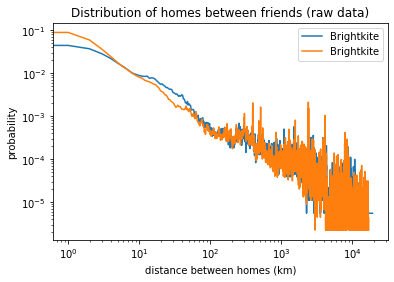

In [13]:
plt.loglog(plot_df_brightkite['distance'],plot_df_brightkite['probability'],label='Brightkite')
plt.legend()
plt.loglog(plot_df_gowalla['distance'],plot_df_gowalla['probability'],label='Brightkite')
plt.legend()

plt.xlabel('distance between homes (km)')
plt.ylabel('probability')
plt.title('Distribution of homes between friends (raw data)')
plt.show()

- We see the the curves aren't smooth and are not easy to interpret $\Rightarrow$ we clean them.  
- We create two functions that will help us have a beautiful plot:  
1) function 'less points' so that we decreqsde noise when distances are big  
2) function 'smooth curve' by taking moving median of each point and avoid abberant values

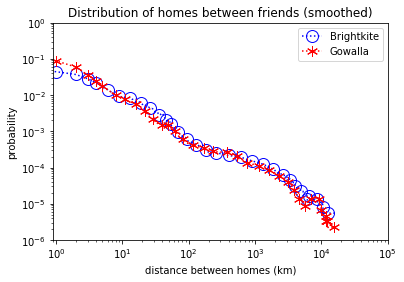

In [26]:
N=50
cut_int=30
where_begin=200
#set markers style to do like paper and plot
ax0=plt.gca()

marker_style_brightkite = dict(color='blue', linestyle=':', marker='o',markersize=12,fillstyle='none')
plt.loglog(less_points(plot_df_brightkite['distance'],cut_int),\
           apply_median(less_points(plot_df_brightkite['probability'],cut_int,where_begin),N),\
           markevery=0.03, **marker_style_brightkite,label='Brightkite')
plt.legend()

plt.loglog(less_points(plot_df_gowalla['distance'],cut_int),\
           apply_median(less_points(plot_df_gowalla['probability'],cut_int,where_begin),N),\
           marker=(6, 2, 0),markevery=0.03,color='r',markersize=11,linestyle=':',label='Gowalla')
plt.legend()

#set xlimit to do like paper
plt.xlim(left=0.9,right=10**5)
plt.ylim(10**-6,1)

plt.xlabel('distance between homes (km)')
plt.ylabel('probability')
plt.title('Distribution of homes between friends (smoothed)')
plt.show()